# Gaining knowledge from tests
#### Max Collard
#### UCSF Neuroscience Orientation 2023

---

# A clairvoyant mouse?

You look at your data, and you see that you **reject the null hypothesis** that *manipulated mice do not predict the future* with a $p$-value of 0.014.

### What do you do with this information?

---

# Let's think about it another way

For the last four weeks, you've been doing nothing but sitting in your room alone studying for your qualifying exam, with **absolutely zero human contact**.

You take it and pass—**hooray!**

But while you've been away studying, UCSF has announced a new policy requiring all graduate students to be tested for Covid-19 daily. You must provide a negative test result before entering any research building on-campus! (*No, not really.*)

You grab a test from one of the Color vending machines and wait at home for the results to come back. The next day, you get an email:

```
SARS-CoV-2 mRNA:    DETECTED
```

# Do you think you have Covid?

## Why do you think that?

---

# Let's scale it up

Right now (9/6/2023), the rolling average for Covid cases in San Francisco is 65 per day. Given that SF's population is about 815,000, this means that the reported incidence of Covid in San Francisco is about 7.97 per 100,000; let's be conservative and say that the prevalence of Covid is about 56 times this (4x to account for under-reporting of tests, and 14x to account for the duration of illness), or 111.6 per 100,000 (though prevalence is, in practice, quite difficult to measure). If you were to pick a person at random from San Francisco with no other knowledge, this would be about the chance of picking someone who currently has Covid.

In [4]:
# September 2021 (using reported case count)
# covid_prevalence = 350 / 100000

# August 2022 (using case count)
# covid_prevalence = 288.4 / 100000

# September 2023 (using 4x reported case count)
covid_prevalence = 446.32 / 100000

### Recall

The $p$-value is defined by thinking about what our observations would be by chance if we **pre-suppose that the null hypothesis is in fact true**:

$$ p = \mathrm{Pr}(\textrm{we observe a difference} \mid \textrm{there is no difference}) $$

> This is convenient to use, because we can always **impose** the null hypothesis by shuffling our data. This is called **permutation testing**.

<img src="figures/ppv/f7.png"/>

<img src="figures/ppv/f6.png" />

Usually, diagnostic tests are evaluated kind of like $p$-values: we use measures that ask how the *test* behaves when we **pre-suppose the truth**.

**Sensitivity** measures the probability that a person tests positive **given that they actually have the disease**:

$$ \mathrm{sensitivity} = \mathrm{Pr}(\textrm{test }+ \mid \textrm{actually }+) $$

**Specificity** measures the probability that a person tests negative **given that they actually *do not* have the disease**:

$$ \mathrm{specificity} = \mathrm{Pr}(\textrm{test }- \mid \textrm{actually }-) $$

<img src="figures/ppv/f8.png"/>

#### N.B.

The $p$-value can be thought of as

$$ p = \mathrm{Pr}(\textrm{test }+ \mid \textrm{actually }-) $$

Because there are only two test outcomes, $+$ and $-$, this means that

$$\begin{eqnarray*}
p & = & 1 - \mathrm{Pr}(\textrm{test }- \mid \textrm{actually }-) \\
& = & 1 - \mathrm{specificity}
\end{eqnarray*}$$

So, the $p$-value is in the same "family" of measures about a test as sensitivity and specificity.

Let's suppose that the currently used RT-PCR test for Covid has approximately the following characteristics:

In [5]:
# September 2021
# rtpcr_sensitivity = 0.777
# rtpcr_specificity = 0.988

# August 2022
rtpcr_sensitivity = 0.733 # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7350782/
rtpcr_specificity = 0.97 # https://www.uptodate.com/contents/covid-19-diagnosis

# September 2023: These characteristics haven't appreciably changed

> (These are based on contemporary literature, although finding these values is quite challenging in practice.)

Note that the $p$-value of this test is:

In [6]:
print( f'p = {1 - rtpcr_specificity:0.4f}' )

p = 0.0300


# You just got a positive test.

## What do the sensitivity and specificity tell you?

---

You already **know** that you've tested positive. What you would like to **infer** is whether or not you actually have Covid.

## Sensitivity and specificity do not tell you this

(And so, neither do **$p$-values**!)

What you want to know are the quantities with the **opposite conditioning**: we **know** the test result once we get it, but we must **infer** the truth about whether we actually have Covid **given** that test result.

<img src="figures/ppv/f9.png"/>

**Positive predictive value** is the probability one *actually has the disease* **given** a positive test result:

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually }+ \mid \textrm{test }+) $$

Now that you have a positive Covid test, the **PPV** is the probability that you **actually** have Covid.

**Negative predictive value** is the probability one *actually does not have the disease* **given** a negative test result:

$$ \mathrm{NPV} = \mathrm{Pr}(\textrm{actually }- \mid \textrm{test }-) $$

<img src="figures/ppv/f10.png"/>

### What do you think are the PPV and NPV for the RT-PCR test?

In [8]:
import numpy as np

# I'm going to be re-using this simulation a lot, so I'll make it a function
def sample_results( n, prevalence, sensitivity, specificity ):
    """Sample disease presence and test results with the given characteristics
    
    Arguments:
    n -- The number of individiuals to sample
    prevalence -- The probability of finding the actual disease in the population
    sensitivity -- The probability of testing positive given one has the disease
    specificity -- The probability of testing negative given one does not have the disease

    Reutrns:
    has_disease -- Shape (n,), whether each individual has the disease
    test_results -- Shape (n,), whether each individual tests positive for the disease
    """
    
    # First, simulate the "truth":
    # The fraction of the time that a uniform random number between 0 and 1
    # is below `prevalence` is ... `prevalence`!
    has_disease = np.random.uniform( size = (n,) ) < prevalence
    
    # Now, use sensitivity and specificity to determine test results based on the truth
    
    # Pre-allocate where I'm going to store the results
    test_results = np.zeros( (n,), dtype = bool )
    # We need a "hidden" random variable to determine the results of each test
    hidden_randoms = np.random.uniform( size = (n,) )
    
    # Iterate over each individual in the population
    # N.B.: I'm doing some Python magic here:
    # * `enumerate` allows me to iterate through a something and also keep track of its index
    # * `zip` allows me to "glue together" two iterable things (like arrays) element by element.
    # Writing my code this way helps prevent me from losing track of what index belongs to what
    for i_individual, (individual_has_disease, individual_hidden) in enumerate( zip( has_disease, hidden_randoms ) ):
        if individual_has_disease:
            # As above, this will be true `sensitivity` portion of the time
            if individual_hidden < sensitivity:
                # *Given* the individual has the disease, `sensitivity` portion of the time,
                # the person will test *positive*
                test_results[i_individual] = True
            else:
                # ... otherwise, they test negative
                test_results[i_individual] = False
        else:
            if individual_hidden < specificity:
                # *Given* the individual *does not* have the disease, `specificity` portion of the time,
                # the person will test *negative*
                test_results[i_individual] = False
            else:
                # ... otherwise, they test positive
                test_results[i_individual] = True
    
    return has_disease, test_results

#### N.B.

Always write docstrings for your code:

In [9]:
help( sample_results )

Help on function sample_results in module __main__:

sample_results(n, prevalence, sensitivity, specificity)
    Sample disease presence and test results with the given characteristics
    
    Arguments:
    n -- The number of individiuals to sample
    prevalence -- The probability of finding the actual disease in the population
    sensitivity -- The probability of testing positive given one has the disease
    specificity -- The probability of testing negative given one does not have the disease
    
    Reutrns:
    has_disease -- Shape (n,), whether each individual has the disease
    test_results -- Shape (n,), whether each individual tests positive for the disease



Let's simulate one day's worth of Covid tests at UCSF:

In [10]:
# Approximately the number of employees at UCSF
n_employees = 24000
# Run our simulation and grab the results
has_covid, rtpcr_positive = sample_results( n_employees,
                                            covid_prevalence,
                                            rtpcr_sensitivity,
                                            rtpcr_specificity )

# If I put an f in front of my string, I can use curly braces to
# put Python code inside of it
print( f'Cases today: {np.sum( has_covid )}' )
print( f'Positive tests today: {np.sum( rtpcr_positive )}' )

Cases today: 98
Positive tests today: 747


Clearly something funky is going on: **there are way more positive tests than cases**!

As is always good practice, let's take a look at a subsample of the raw data:

In [11]:
import matplotlib.pyplot as plt

# I'm going to make the same plot later, so I'll make a function I can reuse so I don't duplicate code
def sample_plot( ax, has_disease, test_results,
                 n_sample = 1000 ):
    """Plot a bit of the data from `sample_results`
    
    Arguments:
    ax -- The axis handle to plot inside of
    has_disease, test_results -- Output from `sample_results
    
    Keyword arguments:
    n_sample -- Number of individuals to show in the plot
    """

    # np.c_ takes two arrays and jams them together as *c*olumns
    # Then, .T *T*ransposes it, so that they're rows
    raster = np.c_[has_disease, test_results].T.astype( float )
    # I only want to display a little part of the whole raster, cause it's huge, so I slice it with :
    raster = raster[:, :n_sample]
    
    # I'm assuming here that I've created an "axes" object that I can plot inside of
    # This makes it so that I can re-use the same function on multiple plots in the same figure!
    ax.imshow( raster,
               aspect = 'auto',
               interpolation = 'none', ) # These are just my personal preferences for image plots

    ax.set_xlabel( 'Sample #' )
    
    ax.set_yticks( [0, 1] )
    ax.set_yticklabels( ['Has Covid?', 'Test Result'],
                        rotation = 45,
                        fontsize = 16 )

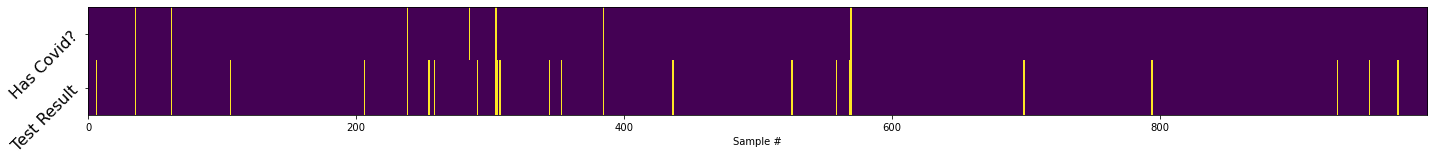

In [12]:
# Subplots allows us to lay out some axes (`ax`) inside of a
# figure (`fig`) that we can manipulate later
fig, ax = plt.subplots( figsize = (24, 2) )
# Use the plotting function we just made on these axes
sample_plot( ax, has_covid, rtpcr_positive )
# We're all done building the plots, we want to displaly them now
plt.show()

By eye, it *definitely* looks like there are a lot of false positives.

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

In [13]:
# Again, I'm going to be doing these computations a lot, so I'll make a function I can re-use
def predictive_value( has_disease, test_results ):
    """Determine positive and negative predictive values from a sample
    
    Arguments:
    has_disease -- Array of bool, whether each individual has the disease
    test_results -- Array of bool, whether each individual tests positive for the disease

    Reutrns:
    ppv -- The sample positive predictive value
    npv -- The sample negative predictive value
    """
    
    # PPV
    n_test_pos = np.sum( test_results )
    # & operates on boolean arrays element by element
    # So `a & b` is an array where each entry is `True` if the corresponding entries of both
    # `a` and `b` are both `True`
    # True positives are those that have the disease *and* test positive
    n_true_pos = np.sum( has_disease & test_results )
    ppv = n_true_pos / n_test_pos
    
    # NPV
    # ~ operates on boolean arrays element by element
    # So `~a` is an array where each entry is `True` if the corresponding entry of `a` is `False`
    n_test_neg = np.sum( ~test_results )
    # True negatives are those that *do not* have the disease *and* *do not* test positive
    n_true_neg = np.sum( (~has_disease) & (~test_results) )
    npv = n_true_neg / n_test_neg
    
    return ppv, npv

### What are the PPV and NPV?

In [14]:
ppv_naive, npv_naive = predictive_value( has_covid, rtpcr_positive )

# We can do math in our curly braces; here I convert the ratios into
# percents. The `:0.2f` at the end tells Python that I want 2 digits
# after the decimal point (not at all intuitive; blame the C people
# who wrote the original `printf` function).
print( f'Naive PPV: {ppv_naive * 100:0.2f}%' )
print( f'Naive NPV: {npv_naive * 100:0.2f}%' )

Naive PPV: 9.77%
Naive NPV: 99.89%


Let's talk about the good news first: 

* A *negative* test is **extremely informative**: if you receive a negative test result, you can say with almost certainty that you are in the clear.

* *However*, in this setup, a *positive* test is **not very informative**: in fact, if you were to receive a positive RT-PCR test, *there is a ~90% chance that you still don't have Covid*. Put another way, **more than 9 out of every 10 positive tests are actually false positives**.

This screening procedure is going to result in hundreds of people being sent into quarantine every day; in fact, if quarantine lasts for ten days (8 work days), then to a first approximation, about 23% of the entire workforce will be quarantining at any given moment from false positive tests alone:

In [15]:
# 10 days is the policy, but a couple of those will be a weekend
quarantine_workdays = 8
# False positives *do not* have Covid *and* test positive
quarantine_false_positives_per_day = np.sum( ~has_covid & rtpcr_positive )
quarantine_false_positives_simultaneous = quarantine_false_positives_per_day * quarantine_workdays
quarantine_fraction = quarantine_false_positives_simultaneous / n_employees

print( f'Fraction of workforce quarantined: {quarantine_fraction * 100:0.2f}%' )

Fraction of workforce quarantined: 22.47%


#### N.B.

This test also has an extremely high **accuracy**, which is the probability of the test being *correct*:

In [16]:
# == operates element by element on arrays
# `a == b` is an array where each element is `True` if the
# corresponding elements of `a` and `b` are equal
accuracy_naive = np.sum( has_covid == rtpcr_positive ) / len( has_covid )

print( f'Naive accuracy: {accuracy_naive * 100:0.2f}%' )

Naive accuracy: 97.09%


But, accuracy as a "summary statistic" of the test is hiding the fact that we're actually doing quite a terrible job with the *positive predictive value*, the much more "actionable" piece of information, because **the prevalence of Covid cases is so low**.

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# What's going wrong?

## Is this a bad test?

## Do you still think you have Covid?

# Let's try something different

In our simulation, the **prevalence** of Covid was thought of as **the probability that someone in our sample had Covid**. We took this to be the prevalence of Covid in San Francisco, under the assumption that we were testing people esssentially randomly, and had no criteria for how we were selecting people to test.

After briefly quarantining a substantial portion of its workforce, UCSF has decided to try a new schema. Now, **only people who have an exposure to a confirmed symptomatic case** will be tested.

While before we had no clue about the people being tested, this new selection criterion means we have more **knowledge** (of the exposure). This knowledge changes our **prior belief**, before even running the test, of whether or not a person being tested has Covid: we *expect* that someone who has had an exposure is more likely to have Covid than someone chosen at random from the general population.

**All of the characteristics of the test itself are still exactly the same**: the same reagents, the same technique, everything. The only thing we'll change to simulate this new scenario is the **proportion of tested people who have Covid**.

Let's say that an exposure to a symptomatic case of Covid carries an associated risk of infection of 5%:

In [17]:
covid_belief_suspicious = 0.05

## What do you think will happen to the PPV of our test in this new scheme?

## How about the NPV?

Let's run a simulation of a group of employees with suspected Covid exposure:

In [18]:
n_suspicious = 1000
has_covid_suspicious, rtpcr_positive_suspicious = sample_results( n_suspicious,
                                                                  covid_belief_suspicious,
                                                                  rtpcr_sensitivity,  # Same as before!
                                                                  rtpcr_specificity ) # Same as before!

# Python is fully Unicode compatible for strings, so there's no
# reason not to include emoji 🤪
print( f'Cases among the suspicious 🤔: {np.sum( has_covid_suspicious )}' )
print( f'Positive tests among the suspicious 🤔: {np.sum( rtpcr_positive_suspicious )}' )

# You can't use emoji in variable names, though 😢

Cases among the suspicious 🤔: 43
Positive tests among the suspicious 🤔: 54


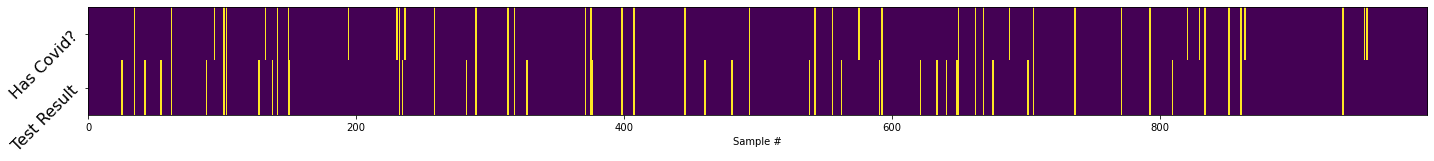

In [20]:
fig, ax = plt.subplots( figsize = (24, 2) )
sample_plot( ax, has_covid_suspicious, rtpcr_positive_suspicious )
plt.show()

Already this is looking much more reasonable. **What are the PPV and the NPV**?

In [21]:
ppv_suspicious, npv_suspicious = predictive_value( has_covid_suspicious, rtpcr_positive_suspicious )

print( f'Suspicious PPV: {ppv_suspicious * 100:0.2f}%' )
print( f'Suspicious NPV: {npv_suspicious * 100:0.2f}%' )

Suspicious PPV: 57.41%
Suspicious NPV: 98.73%


## Aha!

The PPV has jumped dramatically, from about 10% to about 60%!

In this setting—where we have some **additional knowledge** about who we're testing—the **same exact test** has become **a lot more useful**.

<img src="figures/ppv/f11.png"/>

#### N.B.

There is no free lunch, of course; the cost we pay is that the NPV in this scenario is now *slightly* lower!

The critical takeaway message is this:

## How useful a test is depends on our prior belief about the thing we're testing for.

### Let's see how this plays out as we "sweep through" a bunch of different possible priors.

In [22]:
# Fancy progress bar!
from tqdm import tqdm

def belief_sweep( sensitivity, specificity, beliefs,
                  n_sims = 100,
                  n_sample = 1000 ):
    """Determine PPV and NPV across a wide range of priors
    
    Arguments:
    sensitivity, specificity -- The characteristics of the test
    beliefs -- Array of prior beliefs to test
    
    Keyword arguments:
    n_sims -- The number of simulations to run for each prior belief level
    n_sample -- The number of individuals to sample in each simulation
    
    Reutrns:
    ppvs_sweep, npvs_sweep -- Shape (n_beliefs, n_sims)
        Arrays of the PPV and NPV for each simulation at each prior belief level
    """
    
    n_beliefs = len( beliefs )
    
    # Pre-allocate all of the results we're going to get; we'll fill this in as we go!
    ppvs_sweep = np.zeros( (n_beliefs, n_sims) )
    npvs_sweep = np.zeros( (n_beliefs, n_sims) )

    # `tqdm` turns any iterable into a progress bar like magic!
    # `enumerate` doesn't know how long its contents are (they can be infinite!),
    # so we have to tell `tqdm` how long it is if we want it to show the total
    for i_sweep, belief in tqdm( enumerate( beliefs ), total = n_beliefs ):
        # At each level of belief, we'll run `n_sims` number of simulations, to get
        # a solid distribution
        for i_sim in range( n_sims ):
            # Now, because we put all our simulations in functions, we can just call them!
            has_disease, test_positive = sample_results( n_sample,
                                                         belief,
                                                         sensitivity,
                                                         specificity )
            ppvs_sweep[i_sweep, i_sim], npvs_sweep[i_sweep, i_sim] = predictive_value( has_disease, test_positive )
            
    return ppvs_sweep, npvs_sweep

In [23]:
# A convenience function for plotting an error corridor
def plot_band( ax, x, values,
               axis = None,
               mode = 'sd',
               color = '',
               kwargs_plot = dict(),
               kwargs_fill = dict() ):
    """Plot an error corridor derived from `values`
    
    Arguments:
    x -- The horizontal coordinates to plot
    values -- The data array to derive the error corridor from
    
    Keyword arguments:
    axis -- The axis along which to compute dispersion from `values`
        (Default: None, which is the first non-singleton axis)
    mode -- What kind of error corridor to plot. Valid choices are 'sd'
        for standard deviation, and 'se' for standard error.
        (Default: 'sd')
    color -- The color shared by the trace and corridor
        (Default: `matplotlib` next default)
    kwargs_plot, kwargs_fill: Keyword arguments to be passed to `plot` or
        `fill_between`, respectively (Default: empty)
    """
    
    if mode.lower() == 'sd':
        values_middle = np.mean( values, axis = axis )
        values_err = np.std( values, axis = axis )
    elif mode.lower() == 'se':
        values_middle = np.mean( values, axis = axis )
        n = values.shape[axis]
        values_err = (1 / np.sqrt( n )) * np.std( values, axis = axis )
    # TODO: implement median with [0.25, 0.75] quantiles, bootstrap, multiple hypothesis correction, ...
    else:
        # Always good practice to raise Exceptions
        raise ValueError( f'Unknown erorr mode: {mode}' )
    
    # `**kwargs_plot` tells Python to pass this dict to `plot` as keyword arguments
    # This makes it so that I can control any behavior of `plot` (and `fill_between`, below)
    # without having to explicitly write out every argument I want to control beforehand!
    ax.plot( x, values_middle, f'{color}-', **kwargs_plot )
    ax.fill_between( x,
                     values_middle - values_err,
                     values_middle + values_err,
                     color = color,
                     alpha = 0.2,
                     **kwargs_fill )
    
def plot_vline( ax, x, *args, **kwargs ):
    """Plot a vertical line at x-coordinate `x` inside of axes `ax`

    Other arguments or keyword arguments are passed directly to `plot`
    """
    yl = ax.get_ylim()
    ax.plot( [x, x], yl, *args, **kwargs )
    ax.set_ylim( yl )
    
def plot_sweep( ax, beliefs, ppvs, npvs,
                annotations = None,
                xlabel = 'Prior belief' ):
    """Make a summary plot of PPV / NPV results from `belief_sweep`
    
    Arguments:
    ax -- The axes object to plot inside of
    beliefs -- The prior belief values used for the simulations
    ppvs, npvs -- The results from `belief_sweep`
    
    Keyword arguments:
    annotations -- List of tuples of form (x, spec, label)
        Plots a vertical line with the given spec and label at each x
        (Default: no annotations)
    xlabel -- The x-axis label (Default: 'Prior belief')
    """
    
    # Handle default value (None)
    if annotations is None:
        annotations = []
    
    # Here I pass in the 'label' keyword argument so that `matplotlib`
    # makes a nice legend when I call `legend` later
    plot_band( ax, beliefs, ppvs, color = 'b',
               axis = 1,
               kwargs_plot = { 'label': 'PPV'} )
    plot_band( ax, beliefs, npvs, color = 'r',
               axis = 1,
               kwargs_plot = { 'label': 'NPV'} )
    
    for x, spec, label in annotations:
        # Plot a vertical line for each annotation
        plot_vline( ax, x, spec, label = label )
    
    ax.set_xlim( np.min( beliefs ), np.max( beliefs ) )
    
    ax.set_xlabel( xlabel, fontsize = 16 )
    ax.set_ylabel( 'Predictive value', fontsize = 16 )
    ax.legend( fontsize = 16 )

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.75it/s]


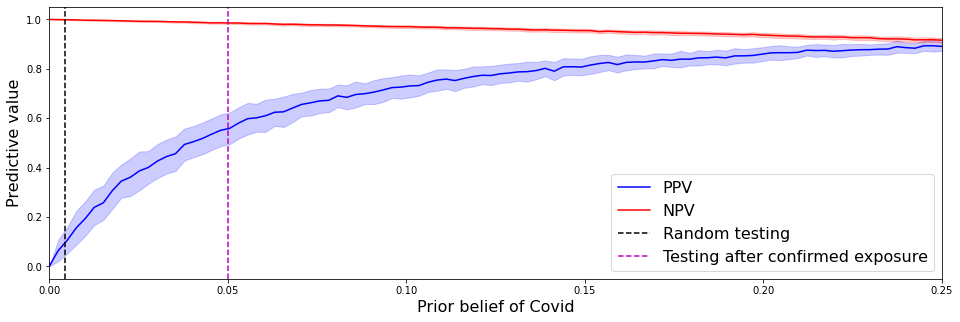

In [24]:
# Run our simulation
# Pick beliefs linearly spaced between 0 and 0.25
covid_beliefs_sweep = np.linspace( 0, 0.25, 100 )
ppvs_sweep, npvs_sweep = belief_sweep( rtpcr_sensitivity,
                                       rtpcr_specificity,
                                       covid_beliefs_sweep )

# Build our plot
fig, ax = plt.subplots( figsize = (16, 5) )
plot_sweep( ax, covid_beliefs_sweep, ppvs_sweep, npvs_sweep,
            annotations = [(covid_prevalence, 'k--', 'Random testing'),
                           (covid_belief_suspicious, 'm--', 'Testing after confirmed exposure')],
            xlabel = 'Prior belief of Covid' )
plt.show()

We can see from the left-hand side of this curve that even **very weak improvements in our prior belief** can lead to **vast changes in the utility of our test**!

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

In these examples, we saw that the PPV of our Covid test depended strongly on the scheme we used to select which people to test, evnen while **the test itself remained entirely the same**.

This means that **PPV is not just a statement about the test**.

## PPV is a statement about how the test is used.

---

# What does a test do?

Before we ran the test, we had some **prior knowledge** about whether we had Covid,

$$ \mathrm{Pr}(\textrm{actually }+) $$

**Once we get a positive test result**, we have new knowledge—the result of the test—which allows us to **update** our belief of whether we have Covid. Our knowledge about whether we have Covid *after* the update caused by the test is precisely the **PPV**:

$$\begin{eqnarray*}
&\mathrm{Pr}(\textrm{actually }+) & \\
& \downarrow & \\
& \mathrm{Pr}(\textrm{actually }+ \mid \textrm{test }+) &
\end{eqnarray*}$$

This is also known as the **posterior probability** (in the sense of "after the test") given a positive test.

<img src="figures/ppv/f12.png"/>

#### N.B.

The amount of information provided by a test result is called the result's **Bayes factor**, $K$. While the PPV—which is the **posterior probability** of disease given a positive test—changes depending on the prior, the following **ratios** are always proportional:

$$ \frac{\mathrm{Pr}(\textrm{actually }+ \mid \textrm{test }+)}{\mathrm{Pr}(\textrm{actually }- \mid \textrm{test }+)} = K\,\frac{\mathrm{Pr}(\textrm{actually }+)}{\mathrm{Pr}(\textrm{actually }-)}$$

So, the Bayes factor tells us how much receiving a positive test result **changes** our prior belief. Test results with larger Bayes factors **change our beliefs more**.

---

# Tests in science

For Covid testing, we obtained some bit of noisy data (a positive test result), and sought to **infer** something about what was **actually** happening (whether we truly have Covid). We made this inference quantitative using the **PPV**:

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually }+ \mid \textrm{test }+) $$

In science, we use **statistical tests**. Just like the Covid RT-PCR, statistical tests are **noisy** bits of data. What we would like to do is to **infer** something about what is **actually** happening in the world on the basis of these test results.

Let's say that you're analyzing some results. You plug two variables you're working on, `x` and `y`, into a magic black box like `scipy.stats.pearsonr`, and it pops out

(The first value is the correlation $r$, the second is the $p$-value.) Cool, it's significant! We got a **positive test result**.

### What do you now know about whether there is actually a relationship between `x` and `y`?

This information, by itself, is **not a statement about whether the null hypothesis is actually true or false**, just as a positive Covid test is not, by itself, a statement about whether you actually have Covid.

## We must infer the truth from the test

### What does this inference depend on?

Now that we have a positive test result, just as in the case of Covid tests, what we're interested in is the **posterior probability**, given that result, of whether there is a relationship between `x` and `y`. This, as we saw before, is precisely the **PPV**:

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually a relationship} \mid \textrm{test rejects null hyp.}) $$

But just as we saw before with Covid tests,

### the PPV will depend on our prior knowledge of whether there is a real relationship between `x` and `y`.

Suppose I got my result by going out into the world and running the `scipy.stats.pearsonr` function between every pair of two datasets I could get my hands on.

What is the probability that any two of those randomly chosen datasets are **actually** causally related to one another? That is, what is the **prior**,

$$ \mathrm{Pr}(\textrm{actually a relationship}) $$

### It is astronomically small.

In this experimental setup of **randomly testing** correlations, what is the **PPV**?

### It is exceedingly low.

So, how do I interpret the result I just saw, that `scipy.stats.pearsonr` rejected the null hypothesis of no relationship between `x` and `y`?

### It is probably a false positive.

# Does that mean that `scipy.stats.pearsonr` is a bad test?

# Is Covid RT-PCR a bad test?

## No.

**PPV** isn't just about the test; PPV depends on **how the test is used**.

### Recall

When looking at Covid testing, **increasing our prior belief of Covid infection to just 5%** raised the PPV from 5% to 60%, **for the exact same test**.

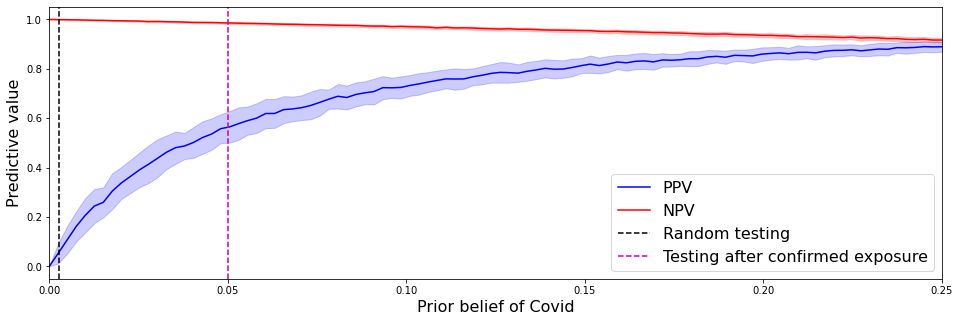

In [33]:
fig, ax = plt.subplots( figsize = (16, 5) )
plot_sweep( ax, covid_beliefs_sweep, ppvs_sweep, npvs_sweep,
            annotations = [(covid_prevalence, 'k--', 'Random testing'),
                           (covid_belief_suspicious, 'm--', 'Testing after confirmed exposure')],
            xlabel = 'Prior belief of Covid' )
plt.show()

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

To make the test's results more meaningful, we used **knowledge** of prior exposure to Covid to **choose who to test**.

### Even very weak information can dramatically improve the utility of a test!

So, how do you **improve the positive predictive value** of testing for significant correlations?

### Choose the right questions to ask.

---

# A clairvoyant mouse?

You look at your data, and you see that you **reject the null hypothesis** that *manipulated mice do not predict the future* with a $p$-value of 0.014.

### What do you now know about whether the mouse is actually clairvoyant?

### Why do you think this?

## What do you do with this information?

---

# Summary

## Tests do not tell us the truth.

### We try to infer the truth from tests.

## Tests update our beliefs about the world.

### We must live in one of the universes where we saw the result we saw.

## The positive predictive value of a test depends on how the test is used.

### In particular, it depends on the prior belief of what we are testing for.

## Statistical testing is not just a matter of selecting the "correct" test for a given question.

Being judicious about selecting the correct **questions** to apply the test *to* is a more powerful way to

* strengthen the inferences gained through statistics

* improve the reproducibility of science

* more responsibly use resources, like experimental animals, that we are ethically obligated to minimize

---

# Follow-up questions

## Decision theory

#### What is a "good" positive or negative predictive value, quantitatively?

#### What do we do once we get a test result?

#### Are false positives and false negatives equally bad? Since there's a tradeoff between PPV and NPV, which should we prioritize making as large as possible?

#### How do we know whether our belief about the prevalence of Covid is correct?

#### How do we know how accurate our prior belief about a statement in science is?

---

## How do we choose the next test to run?

This is a **big** question, so let's think about it in the context of a few specific examples.

## Accumulating evidence

Let's say we run a second experiment with a second test. Now I can **update** my knowledge **again**:
 
$$
\begin{eqnarray*}
    & \mathrm{Pr}(\textrm{statement}) & \\
    & \downarrow & \\
    & \mathrm{Pr}(\textrm{statement} \mid \textrm{test 1 }+) & \\
    & \downarrow & \\
    & \mathrm{Pr}(\textrm{statement} \mid \textrm{test 1 }+,\textrm{test 2 }+) & \\
    & \downarrow & \\
    & \cdots &
\end{eqnarray*}
$$

And so on, for test after test.

<img src="figures/ppv/f2.png">

#### How deep does this rabbit hole go?
#### What does this process converge to? Does it converge at all?
#### What does this convergence depend on?

Let's say we **update** our belief with successive tests, as above, but at each step, we choose the next test such that it will **maximally increase our updated probability**, $\mathrm{Pr}(\textrm{statement} \mid \textrm{tests})$.

That is, we choose the experiment that we think will **give us the most evidence supporting our model**.

### What does this process converge to?

Let's say we **update** our belief with successive tests, as above, but at each step, we choose the next test **completely at random**.

### What does this process converge to?

Let's say we **update** our belief with successive tests, but we are **really wrong** about our initial belief.

#### What happens to the limit?

#### Will our belief always end up in the same place at the end of the process, regardless of what we initially think?

#### What is the best initial belief to have?

## Comparing models

Let's say we **update** our belief with successive tests, but this time, we look at **multiple** candidate models; i.e., we obtain

$$
\begin{eqnarray*}
    &\mathrm{Pr}(\textrm{model 1} \mid \textrm{test 1},\cdots,\textrm{test }n) \\
    &\mathrm{Pr}(\textrm{model 2} \mid \textrm{test 1},\cdots,\textrm{test }n) \\
    &\cdots \\
    &\mathrm{Pr}(\textrm{model }k \mid \textrm{test 1},\cdots,\textrm{test }n)
\end{eqnarray*}
$$

after a sequence of $n$ tests.

<img src="figures/ppv/f3.png"/>

#### Does the presence of multiple candidate models change the way we should choose the next test?

In the above scheme with multiple candidate models, let's say that the **truth** is **not** among the models that you considered.

#### What does this process converge to?

#### How do you interpret the result?

#### How do you know whether you included the truth as a candidate model?

## History dependence

The process of updating our beliefs about our model is kind of like an **optimization problem**.

Imagine that there is some "landscape" painted across the space of all models we're considering, with the "height" at each point (each model) corresponding to the "badness" of that model.

For example, models are worse (higher up) if they have a bigger **prediction error**.

Our goal is to incrementally update what we *think* the best model is, in order to someday find the lowest point in the entire landscape—the **actual best** model—which should be the **truth**.

<img src="figures/ppv/f4.png" />

After each experiment we run, we collect new data.

This new data changes how we measure the badness or goodness of a model's fit—after all, the model should fit the new data, too!

This **alters the landscape** of our optimization problem.

<img src="figures/ppv/f5.png" />

#### What happens if we start off very wrong about our prediction of what model is best?

#### Does our optimization process converge to the truth?

#### How can we ever "recover"?

#### Is this new minimum *actually* the truth? That is, was our notion of truth—our "landscape"—wrong to begin with?

#### Was the evidence that "eroded" the landscape actually *helpful*? Or was this erosion a result of our bias from an incorrect prediction?

## How does the optimum we converge to depend on how we choose the next test to run?

#### If we had started off the entire process with a vastly different initial prediction, would *yet another* minimum have emerged? Is *that* the truth?

#### Is there a criterion for optimality that is independent of our starting position?

#### Can we design a scheme for conducting tests that makes us more likely to converge to that "optimum" model, regardless of our initial beliefs?

#### Is any of this even a problem?

#### Should we try to design scientific inquiry so that the effect of this history dependence, or "erosion" of the landscape, is minimized? Or is this an important feature of how science behaves?

#### Is the model we converge to through this process a statement about the world we live in, or just a statement about the process *itself*?

## What would scientific "truth" look like today if we had had different structures in place for how we conduct science all along?

## What amazing ideas have we missed out on?